# Static

Performing static torque analysis across all configurations...


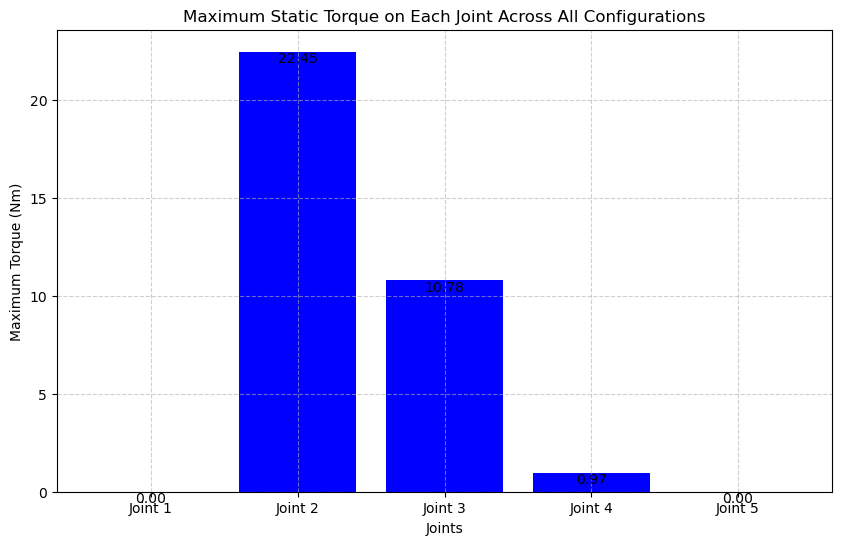

Maximum Torques for given values: [0.0, 22.44698101561474, 10.776096405704976, 0.9660964057049761, 0.0]
Maximum Torques for given values: [0.0, 22.44698101561474, 10.776096405704976, 0.9660964057049761, 0.0]


In [14]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the computation function
def compute_torques(d_1_val, d_5_val, a_2_val, a_3_val, masses, mass_camera, mass_lights, external_forces, external_torques):
    # Define symbolic variables for joint angles, DH parameters, masses
    theta_1, theta_2, theta_3, theta_4, theta_5 = sp.symbols("theta_1 theta_2 theta_3 theta_4 theta_5")
    d_1, d_5 = sp.symbols("d_1 d_5")
    a_2, a_3 = sp.symbols("a_2 a_3")
    alpha = [90, 0, 0, 90, 0]
    m1, m2, m3, m4, m5 = sp.symbols("m1 m2 m3 m4 m5")
    g = sp.Matrix([0, 0, -9.81])

    # Helper function to create a transformation matrix from DH parameters
    def dh_matrix(theta, d, a, alpha):
        alpha_rad = sp.rad(alpha)
        return sp.Matrix(
            [
                [sp.cos(theta), -sp.sin(theta) * sp.cos(alpha_rad), sp.sin(theta) * sp.sin(alpha_rad), a * sp.cos(theta)],
                [sp.sin(theta), sp.cos(theta) * sp.cos(alpha_rad), -sp.cos(theta) * sp.sin(alpha_rad), a * sp.sin(theta)],
                [0, sp.sin(alpha_rad), sp.cos(alpha_rad), d],
                [0, 0, 0, 1],
            ]
        )

    # Create transformation matrices
    A1 = dh_matrix(theta_1, d_1, 0, alpha[0])
    A2 = dh_matrix(theta_2, 0, a_2, alpha[1])
    A3 = dh_matrix(theta_3, 0, a_3, alpha[2])
    A4 = dh_matrix(theta_4, 0, 0, alpha[3])
    A5 = dh_matrix(theta_5, d_5, 0, alpha[4])

    # Compute the individual transformation matrices
    T1 = A1
    T2 = T1 * A2
    T3 = T2 * A3
    T4 = T3 * A4
    T5 = T4 * A5

    # Extract positions of each link's center of mass
    # Assume center of mass at the middle of each link for simplicity
    p1 = T1[:3, 3] / 2
    p2 = T2[:3, 3] / 2
    p3 = T3[:3, 3] / 2
    p4 = T4[:3, 3] / 2
    p5 = T5[:3, 3] / 2

    # Compute the Jacobians for each center of mass
    Jv1 = p1.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv2 = p2.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv3 = p3.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv4 = p4.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv5 = p5.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # Compute the gravity vector for each link (assuming center of mass at the link origin)
    G1 = m1 * g
    G2 = m2 * g
    G3 = m3 * g
    G4 = m4 * g
    G5 = (m5 + mass_camera + mass_lights) * g  # Adding camera and lights masses to the last link

    # Compute the torques due to gravity for each link
    tau_g1 = Jv1.T * G1
    tau_g2 = Jv2.T * G2
    tau_g3 = Jv3.T * G3
    tau_g4 = Jv4.T * G4
    tau_g5 = Jv5.T * G5

    # Define symbolic variables for external forces and torques
    F_ext_x, F_ext_y, F_ext_z = sp.symbols("F_ext_x F_ext_y F_ext_z")
    T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5 = sp.symbols("T_ext_1 T_ext_2 T_ext_3 T_ext_4 T_ext_5")

    F_ext = sp.Matrix([F_ext_x, F_ext_y, F_ext_z])
    T_ext = sp.Matrix([T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5])

    # Compute the Jacobian for the external force application point (assuming it is the end effector)
    Jv_ext = T5[:3, 3].jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # Compute the torques due to external forces and torques
    tau_ext_forces = Jv_ext.T * F_ext
    tau_ext = tau_ext_forces + T_ext

    # Sum the torques due to gravity and external forces/torques
    tau_total = tau_g1 + tau_g2 + tau_g3 + tau_g4 + tau_g5 + tau_ext

    # Simplify the total torques
    tau_total_simplified = sp.simplify(tau_total)

    # Provide numerical values for testing
    values = {
        d_1: d_1_val,
        d_5: d_5_val,
        a_2: a_2_val,
        a_3: a_3_val,
        m1: masses[0],
        m2: masses[1],
        m3: masses[2],
        m4: masses[3],
        m5: masses[4],
        F_ext_x: external_forces[0],
        F_ext_y: external_forces[1],
        F_ext_z: external_forces[2],
        T_ext_1: external_torques[0],
        T_ext_2: external_torques[1],
        T_ext_3: external_torques[2],
        T_ext_4: external_torques[3],
        T_ext_5: external_torques[4],
    }

    # Initialize the maximum torque tracker
    max_torque_per_joint = np.zeros(5)

    # Define the range for joint angles
    angle_range = np.linspace(-np.pi, np.pi, 10)  # 10 steps from -π to π

    # Generate all combinations of joint angles
    angle_combinations = product(angle_range, repeat=5)

    # Precompute torque function
    tau_total_func = sp.lambdify(
        (theta_1, theta_2, theta_3, theta_4, theta_5),
        tau_total_simplified.subs(values),
        "numpy",
    )

    # Iterate over all angle combinations and compute torques
    for angles in angle_combinations:
        numerical_torques = np.array(tau_total_func(*angles), dtype=float).flatten()
        max_torque_per_joint = np.maximum(max_torque_per_joint, np.abs(numerical_torques))

    # Plot the maximum torques
    joints = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(joints, max_torque_per_joint.tolist(), color="blue")
    plt.xlabel("Joints")
    plt.ylabel("Maximum Torque (Nm)")
    plt.title("Maximum Static Torque on Each Joint Across All Configurations")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            va="bottom" if yval < 0 else "top",
            ha="center",
            color="black",
        )

    plt.show()

    # Print the maximum torques
    print(f"Maximum Torques for given values: {max_torque_per_joint.tolist()}")
    return max_torque_per_joint.tolist()


# Experiment with different values
d_1_val = 0.1
d_5_val = 0.1
a_2_val = 0.5
a_3_val = 0.5
masses = [1.0, 1.0, 1.0, 1.0, 1.0]
mass_camera = 0.5
mass_lights = 0.5
external_forces = [0, 0, 0]  # No external forces in this example
external_torques = [0, 0, 0, 0, 0]  # No external torques in this example

# Note: This is a static analysis
print("Performing static torque analysis across all configurations...")
max_torque_per_joint = compute_torques(
    d_1_val,
    d_5_val,
    a_2_val,
    a_3_val,
    masses,
    mass_camera,
    mass_lights,
    external_forces,
    external_torques,
)

print(f"Maximum Torques for given values: {max_torque_per_joint}")


# Dynamic + zero vel _ acc

Performing dynamic torque analysis across all configurations...


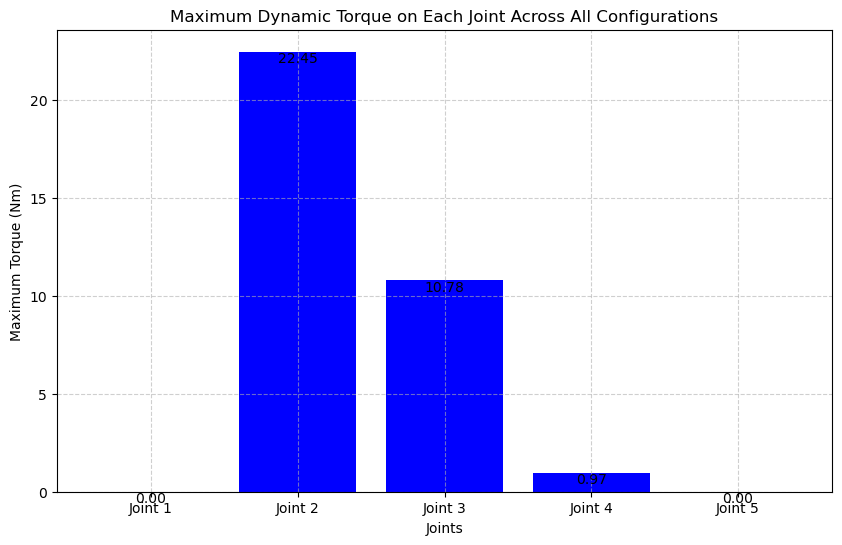

Maximum Dynamic Torques for given values: [0.0, 22.44698101561474, 10.776096405704976, 0.9660964057049761, 0.0]
Maximum Dynamic Torques for given values: [0.0, 22.44698101561474, 10.776096405704976, 0.9660964057049761, 0.0]


In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the computation function for dynamic analysis
def compute_dynamic_torques(d_1_val, d_5_val, a_2_val, a_3_val, masses, inertias, mass_camera, mass_lights, external_forces, external_torques, joint_velocities, joint_accelerations):
    # Define symbolic variables for joint angles, velocities, accelerations, DH parameters, masses, and inertia
    theta_1, theta_2, theta_3, theta_4, theta_5 = sp.symbols("theta_1 theta_2 theta_3 theta_4 theta_5")
    d_1, d_5 = sp.symbols("d_1 d_5")
    a_2, a_3 = sp.symbols("a_2 a_3")
    alpha = [90, 0, 0, 90, 0]
    m1, m2, m3, m4, m5 = sp.symbols("m1 m2 m3 m4 m5")
    g = sp.Matrix([0, 0, -9.81])
    dq1, dq2, dq3, dq4, dq5 = sp.symbols("dq1 dq2 dq3 dq4 dq5")  # Joint velocities
    ddq1, ddq2, ddq3, ddq4, ddq5 = sp.symbols("ddq1 ddq2 ddq3 ddq4 ddq5")  # Joint accelerations

    # Define inertia matrices (assuming simple diagonal form for simplicity)
    I1_xx, I1_yy, I1_zz = sp.symbols("I1_xx I1_yy I1_zz")
    I2_xx, I2_yy, I2_zz = sp.symbols("I2_xx I2_yy I2_zz")
    I3_xx, I3_yy, I3_zz = sp.symbols("I3_xx I3_yy I3_zz")
    I4_xx, I4_yy, I4_zz = sp.symbols("I4_xx I4_yy I4_zz")
    I5_xx, I5_yy, I5_zz = sp.symbols("I5_xx I5_yy I5_zz")

    I1 = sp.diag(I1_xx, I1_yy, I1_zz)
    I2 = sp.diag(I2_xx, I2_yy, I2_zz)
    I3 = sp.diag(I3_xx, I3_yy, I3_zz)
    I4 = sp.diag(I4_xx, I4_yy, I4_zz)
    I5 = sp.diag(I5_xx, I5_yy, I5_zz)

    # Helper function to create a transformation matrix from DH parameters
    def dh_matrix(theta, d, a, alpha):
        alpha_rad = sp.rad(alpha)
        return sp.Matrix(
            [
                [sp.cos(theta), -sp.sin(theta) * sp.cos(alpha_rad), sp.sin(theta) * sp.sin(alpha_rad), a * sp.cos(theta)],
                [sp.sin(theta), sp.cos(theta) * sp.cos(alpha_rad), -sp.cos(theta) * sp.sin(alpha_rad), a * sp.sin(theta)],
                [0, sp.sin(alpha_rad), sp.cos(alpha_rad), d],
                [0, 0, 0, 1],
            ]
        )

    # Create transformation matrices
    A1 = dh_matrix(theta_1, d_1, 0, alpha[0])
    A2 = dh_matrix(theta_2, 0, a_2, alpha[1])
    A3 = dh_matrix(theta_3, 0, a_3, alpha[2])
    A4 = dh_matrix(theta_4, 0, 0, alpha[3])
    A5 = dh_matrix(theta_5, d_5, 0, alpha[4])

    # Compute the individual transformation matrices
    T1 = A1
    T2 = T1 * A2
    T3 = T2 * A3
    T4 = T3 * A4
    T5 = T4 * A5

    # Extract positions of each link's center of mass
    # Assume center of mass at the middle of each link for simplicity
    p1 = T1[:3, 3] / 2
    p2 = T2[:3, 3] / 2
    p3 = T3[:3, 3] / 2
    p4 = T4[:3, 3] / 2
    p5 = T5[:3, 3] / 2

    # Compute the Jacobians for each center of mass
    Jv1 = p1.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv2 = p2.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv3 = p3.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv4 = p4.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
    Jv5 = p5.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # Compute the gravity vector for each link (assuming center of mass at the link origin)
    G1 = m1 * g
    G2 = m2 * g
    G3 = m3 * g
    G4 = m4 * g
    G5 = (m5 + mass_camera + mass_lights) * g  # Adding camera and lights masses to the last link

    # Compute the torques due to gravity for each link
    tau_g1 = Jv1.T * G1
    tau_g2 = Jv2.T * G2
    tau_g3 = Jv3.T * G3
    tau_g4 = Jv4.T * G4
    tau_g5 = Jv5.T * G5

    # Define symbolic variables for external forces and torques
    F_ext_x, F_ext_y, F_ext_z = sp.symbols("F_ext_x F_ext_y F_ext_z")
    T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5 = sp.symbols("T_ext_1 T_ext_2 T_ext_3 T_ext_4 T_ext_5")

    F_ext = sp.Matrix([F_ext_x, F_ext_y, F_ext_z])
    T_ext = sp.Matrix([T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5])

    # Compute the Jacobian for the external force application point (assuming it is the end effector)
    Jv_ext = T5[:3, 3].jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

    # Compute the torques due to external forces and torques
    tau_ext_forces = Jv_ext.T * F_ext
    tau_ext = tau_ext_forces + T_ext

    # Sum the torques due to gravity and external forces/torques
    tau_static = tau_g1 + tau_g2 + tau_g3 + tau_g4 + tau_g5 + tau_ext

    # Inertia Matrix (M)
    M = sp.Matrix.zeros(5, 5)
    M += Jv1.T * m1 * Jv1 + Jv2.T * m2 * Jv2 + Jv3.T * m3 * Jv3 + Jv4.T * m4 * Jv4 + Jv5.T * m5 * Jv5

    # Coriolis and Centrifugal Matrix (C)
    C = sp.Matrix.zeros(5, 5)
    dq = sp.Matrix([dq1, dq2, dq3, dq4, dq5])
    for i in range(5):
        for j in range(5):
            C[i, j] = 0
            for k in range(5):
                C[i, j] += 0.5 * (M[i, j].diff(dq[k]) + M[i, k].diff(dq[j]) - M[j, k].diff(dq[i])) * dq[k]

    # Generalized Torques (tau)
    tau_dynamic = M * sp.Matrix([ddq1, ddq2, ddq3, ddq4, ddq5]) + C * sp.Matrix([dq1, dq2, dq3, dq4, dq5]) + tau_static

    # Simplify the total torques
    tau_dynamic_simplified = sp.simplify(tau_dynamic)

    # Provide numerical values for testing
    values = {
        d_1: d_1_val,
        d_5: d_5_val,
        a_2: a_2_val,
        a_3: a_3_val,
        m1: masses[0],
        m2: masses[1],
        m3: masses[2],
        m4: masses[3],
        m5: masses[4],
        I1_xx: inertias[0][0],
        I1_yy: inertias[0][1],
        I1_zz: inertias[0][2],
        I2_xx: inertias[1][0],
        I2_yy: inertias[1][1],
        I2_zz: inertias[1][2],
        I3_xx: inertias[2][0],
        I3_yy: inertias[2][1],
        I3_zz: inertias[2][2],
        I4_xx: inertias[3][0],
        I4_yy: inertias[3][1],
        I4_zz: inertias[3][2],
        I5_xx: inertias[4][0],
        I5_yy: inertias[4][1],
        I5_zz: inertias[4][2],
        F_ext_x: external_forces[0],
        F_ext_y: external_forces[1],
        F_ext_z: external_forces[2],
        T_ext_1: external_torques[0],
        T_ext_2: external_torques[1],
        T_ext_3: external_torques[2],
        T_ext_4: external_torques[3],
        T_ext_5: external_torques[4],
        dq1: joint_velocities[0],
        dq2: joint_velocities[1],
        dq3: joint_velocities[2],
        dq4: joint_velocities[3],
        dq5: joint_velocities[4],
        ddq1: joint_accelerations[0],
        ddq2: joint_accelerations[1],
        ddq3: joint_accelerations[2],
        ddq4: joint_accelerations[3],
        ddq5: joint_accelerations[4],
    }

    # Initialize the maximum torque tracker
    max_torque_per_joint = np.zeros(5)

    # Define the range for joint angles
    angle_range = np.linspace(-np.pi, np.pi, 10)  # 10 steps from -π to π

    # Generate all combinations of joint angles
    angle_combinations = product(angle_range, repeat=5)

    # Precompute torque function
    tau_dynamic_func = sp.lambdify(
        (theta_1, theta_2, theta_3, theta_4, theta_5),
        tau_dynamic_simplified.subs(values),
        "numpy",
    )

    # Iterate over all angle combinations and compute torques
    for angles in angle_combinations:
        numerical_torques = np.array(tau_dynamic_func(*angles), dtype=float).flatten()
        max_torque_per_joint = np.maximum(max_torque_per_joint, np.abs(numerical_torques))

    # Plot the maximum torques
    joints = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(joints, max_torque_per_joint.tolist(), color="blue")
    plt.xlabel("Joints")
    plt.ylabel("Maximum Torque (Nm)")
    plt.title("Maximum Dynamic Torque on Each Joint Across All Configurations")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            va="bottom" if yval < 0 else "top",
            ha="center",
            color="black",
        )

    plt.show()

    # Print the maximum torques
    print(f"Maximum Dynamic Torques for given values: {max_torque_per_joint.tolist()}")
    return max_torque_per_joint.tolist()

# Experiment with different values
d_1_val = 0.1
d_5_val = 0.1
a_2_val = 0.5
a_3_val = 0.5
masses = [1.0, 1.0, 1.0, 1.0, 1.0]
inertias = [
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
]
mass_camera = 0.5
mass_lights = 0.5
external_forces = [0, 0, 0]  # No external forces in this example
external_torques = [0, 0, 0, 0, 0]  # No external torques in this example
joint_velocities = [0, 0, 0, 0, 0]  # Example joint velocities
joint_accelerations = [0, 0, 0, 0, 0]  # Example joint accelerations

# Note: This is a dynamic analysis
print("Performing dynamic torque analysis across all configurations...")
max_torque_per_joint = compute_dynamic_torques(
    d_1_val,
    d_5_val,
    a_2_val,
    a_3_val,
    masses,
    inertias,
    mass_camera,
    mass_lights,
    external_forces,
    external_torques,
    joint_velocities,
    joint_accelerations,
)

print(f"Maximum Dynamic Torques for given values: {max_torque_per_joint}")


# Dynmaic with varying vel _ acc

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Helper function to create a transformation matrix from DH parameters
def dh_matrix(theta, d, a, alpha):
    alpha_rad = sp.rad(alpha)
    return sp.Matrix(
        [
            [
                sp.cos(theta),
                -sp.sin(theta) * sp.cos(alpha_rad),
                sp.sin(theta) * sp.sin(alpha_rad),
                a * sp.cos(theta),
            ],
            [
                sp.sin(theta),
                sp.cos(theta) * sp.cos(alpha_rad),
                -sp.cos(theta) * sp.sin(alpha_rad),
                a * sp.sin(theta),
            ],
            [0, sp.sin(alpha_rad), sp.cos(alpha_rad), d],
            [0, 0, 0, 1],
        ]
    )

# Define symbolic variables
theta_1, theta_2, theta_3, theta_4, theta_5 = sp.symbols("theta_1 theta_2 theta_3 theta_4 theta_5")
d_1, d_5 = sp.symbols("d_1 d_5")
a_2, a_3 = sp.symbols("a_2 a_3")
alpha = [90, 0, 0, 90, 0]
m1, m2, m3, m4, m5 = sp.symbols("m1 m2 m3 m4 m5")
g = sp.Matrix([0, 0, -9.81])
dq1, dq2, dq3, dq4, dq5 = sp.symbols("dq1 dq2 dq3 dq4 dq5")
ddq1, ddq2, ddq3, ddq4, ddq5 = sp.symbols("ddq1 ddq2 ddq3 ddq4 ddq5")

# Define inertia matrices (assuming simple diagonal form for simplicity)
I1_xx, I1_yy, I1_zz = sp.symbols("I1_xx I1_yy I1_zz")
I2_xx, I2_yy, I2_zz = sp.symbols("I2_xx I2_yy I2_zz")
I3_xx, I3_yy, I3_zz = sp.symbols("I3_xx I3_yy I3_zz")
I4_xx, I4_yy, I4_zz = sp.symbols("I4_xx I4_yy I4_zz")
I5_xx, I5_yy, I5_zz = sp.symbols("I5_xx I5_yy I5_zz")

# Define the DH parameters and transformation matrices
A1 = dh_matrix(theta_1, d_1, 0, alpha[0])
A2 = dh_matrix(theta_2, 0, a_2, alpha[1])
A3 = dh_matrix(theta_3, 0, a_3, alpha[2])
A4 = dh_matrix(theta_4, 0, 0, alpha[3])
A5 = dh_matrix(theta_5, d_5, 0, alpha[4])

# Compute the individual transformation matrices
T1 = A1
T2 = T1 * A2
T3 = T2 * A3
T4 = T3 * A4
T5 = T4 * A5

# Extract positions of each link's center of mass
p1 = T1[:3, 3] / 2
p2 = T2[:3, 3] / 2
p3 = T3[:3, 3] / 2
p4 = T4[:3, 3] / 2
p5 = T5[:3, 3] / 2

# Compute the Jacobians for each center of mass
Jv1 = p1.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
Jv2 = p2.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
Jv3 = p3.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
Jv4 = p4.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])
Jv5 = p5.jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

# Compute the gravity vector for each link (assuming center of mass at the link origin)
G1 = m1 * g
G2 = m2 * g
G3 = m3 * g
G4 = m4 * g
G5 = (m5 + 0.5 + 0.5) * g  # Adding camera and lights masses to the last link

# Compute the torques due to gravity for each link
tau_g1 = Jv1.T * G1
tau_g2 = Jv2.T * G2
tau_g3 = Jv3.T * G3
tau_g4 = Jv4.T * G4
tau_g5 = Jv5.T * G5

# Define symbolic variables for external forces and torques
F_ext_x, F_ext_y, F_ext_z = sp.symbols("F_ext_x F_ext_y F_ext_z")
T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5 = sp.symbols("T_ext_1 T_ext_2 T_ext_3 T_ext_4 T_ext_5")

F_ext = sp.Matrix([F_ext_x, F_ext_y, F_ext_z])
T_ext = sp.Matrix([T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5])

# Compute the Jacobian for the external force application point (assuming it is the end effector)
Jv_ext = T5[:3, 3].jacobian([theta_1, theta_2, theta_3, theta_4, theta_5])

# Compute the torques due to external forces and torques
tau_ext_forces = Jv_ext.T * F_ext
tau_ext = tau_ext_forces + T_ext

# Sum the torques due to gravity and external forces/torques
tau_static = tau_g1 + tau_g2 + tau_g3 + tau_g4 + tau_g5 + tau_ext

# Inertia Matrix (M)
M = sp.Matrix.zeros(5, 5)
M += Jv1.T * m1 * Jv1 + Jv2.T * m2 * Jv2 + Jv3.T * m3 * Jv3 + Jv4.T * m4 * Jv4 + Jv5.T * m5 * Jv5

# Coriolis and Centrifugal Matrix (C)
C = sp.Matrix.zeros(5, 5)
dq = sp.Matrix([dq1, dq2, dq3, dq4, dq5])
for i in range(5):
    for j in range(5):
        C[i, j] = 0
        for k in range(5):
            C[i, j] += 0.5 * (M[i, j].diff(dq[k]) + M[i, k].diff(dq[j]) - M[j, k].diff(dq[i])) * dq[k]

# Generalized Torques (tau)
tau_dynamic = M * sp.Matrix([ddq1, ddq2, ddq3, ddq4, ddq5]) + C * sp.Matrix([dq1, dq2, dq3, dq4, dq5]) + tau_static

# Simplify the total torques
tau_dynamic_simplified = sp.simplify(tau_dynamic)

# Provide numerical values for testing
values = {
    d_1: 0.1,
    d_5: 0.1,
    a_2: 0.5,
    a_3: 0.5,
    m1: 1.0,
    m2: 1.0,
    m3: 1.0,
    m4: 1.0,
    m5: 1.0,
    I1_xx: 0.1,
    I1_yy: 0.1,
    I1_zz: 0.1,
    I2_xx: 0.1,
    I2_yy: 0.1,
    I2_zz: 0.1,
    I3_xx: 0.1,
    I3_yy: 0.1,
    I3_zz: 0.1,
    I4_xx: 0.1,
    I4_yy: 0.1,
    I4_zz: 0.1,
    I5_xx: 0.1,
    I5_yy: 0.1,
    I5_zz: 0.1,
    F_ext_x: 0,
    F_ext_y: 0,
    F_ext_z: 0,
    T_ext_1: 0,
    T_ext_2: 0,
    T_ext_3: 0,
    T_ext_4: 0,
    T_ext_5: 0,
}

# Precompute torque function
tau_dynamic_func = sp.lambdify(
    (theta_1, theta_2, theta_3, theta_4, theta_5, dq1, dq2, dq3, dq4, dq5, ddq1, ddq2, ddq3, ddq4, ddq5),
    tau_dynamic_simplified.subs(values),
    "numpy",
)

# Create a list of all angle combinations
angle_range = np.linspace(-np.pi, np.pi, 10)
angle_combinations = np.array(list(product(angle_range, repeat=5)))

# Define extreme values for velocities and accelerations
velocity_extremes = [-1, 0, 1]  # Include -1, 0, and 1 as extreme values
acceleration_extremes = [-1, 0, 1]  # Include -1, 0, and 1 as extreme values

# Initialize the maximum torque tracker
max_torque_per_joint = np.zeros(5)

# Iterate over all combinations and compute torques
for angles in angle_combinations:
    for velocities in product(velocity_extremes, repeat=5):
        for accelerations in product(acceleration_extremes, repeat=5):
            torques = np.array(tau_dynamic_func(*angles, *velocities, *accelerations), dtype=float).flatten()
            max_torque_per_joint = np.maximum(max_torque_per_joint, np.abs(torques))

# Plot the maximum torques
joints = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5"]

plt.figure(figsize=(10, 6))
bars = plt.bar(joints, max_torque_per_joint.tolist(), color="blue")
plt.xlabel("Joints")
plt.ylabel("Maximum Torque (Nm)")
plt.title("Maximum Dynamic Torque on Each Joint Across All Configurations")
plt.grid(True, linestyle="--", alpha=0.6)

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", va="bottom" if yval < 0 else "top", ha="center", color="black")

plt.show()

# Print the maximum torques
print(f"Maximum Dynamic Torques for given values: {max_torque_per_joint.tolist()}")


## with interias 

### there are bugs in the code below 

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def compute_dynamic_torques(d_1_val, d_5_val, a_2_val, a_3_val, masses, mass_camera, mass_lights, external_forces, external_torques):
    """
    Compute the maximum dynamic torques for a robotic arm across all configurations.
    
    Parameters:
    d_1_val (float): DH parameter d_1.
    d_5_val (float): DH parameter d_5.
    a_2_val (float): DH parameter a_2.
    a_3_val (float): DH parameter a_3.
    masses (list): List of masses for each link.
    mass_camera (float): Mass of the camera attached to the last link.
    mass_lights (float): Mass of the lights attached to the last link.
    external_forces (list): External forces acting on the end effector [F_ext_x, F_ext_y, F_ext_z].
    external_torques (list): External torques acting on each joint [T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5].
    
    Returns:
    list: Maximum torques for each joint.
    """
    # Define symbolic variables for joint angles, DH parameters, velocities, accelerations, and masses
    theta = sp.symbols("theta_1 theta_2 theta_3 theta_4 theta_5")
    theta_dot = sp.symbols("theta_dot_1 theta_dot_2 theta_dot_3 theta_dot_4 theta_dot_5")
    theta_ddot = sp.symbols("theta_ddot_1 theta_ddot_2 theta_ddot_3 theta_ddot_4 theta_ddot_5")
    d_1, d_5 = sp.symbols("d_1 d_5")
    a_2, a_3 = sp.symbols("a_2 a_3")
    alpha = [90, 0, 0, 90, 0]
    m1, m2, m3, m4, m5 = sp.symbols("m1 m2 m3 m4 m5")
    g = sp.Matrix([0, 0, -9.81])

    def dh_matrix(theta, d, a, alpha):
        """Create a transformation matrix from DH parameters."""
        alpha_rad = sp.rad(alpha)
        return sp.Matrix([
            [sp.cos(theta), -sp.sin(theta) * sp.cos(alpha_rad), sp.sin(theta) * sp.sin(alpha_rad), a * sp.cos(theta)],
            [sp.sin(theta), sp.cos(theta) * sp.cos(alpha_rad), -sp.cos(theta) * sp.sin(alpha_rad), a * sp.sin(theta)],
            [0, sp.sin(alpha_rad), sp.cos(alpha_rad), d],
            [0, 0, 0, 1]
        ])

    # Create transformation matrices
    A1 = dh_matrix(theta[0], d_1, 0, alpha[0])
    A2 = dh_matrix(theta[1], 0, a_2, alpha[1])
    A3 = dh_matrix(theta[2], 0, a_3, alpha[2])
    A4 = dh_matrix(theta[3], 0, 0, alpha[3])
    A5 = dh_matrix(theta[4], d_5, 0, alpha[4])

    # Compute the individual transformation matrices
    T1 = A1
    T2 = T1 * A2
    T3 = T2 * A3
    T4 = T3 * A4
    T5 = T4 * A5

    # Extract positions of each link's center of mass
    p1 = T1[:3, 3] / 2
    p2 = T2[:3, 3] / 2
    p3 = T3[:3, 3] / 2
    p4 = T4[:3, 3] / 2
    p5 = T5[:3, 3] / 2

    # Compute the Jacobians for each center of mass
    Jv1 = p1.jacobian(theta)
    Jv2 = p2.jacobian(theta)
    Jv3 = p3.jacobian(theta)
    Jv4 = p4.jacobian(theta)
    Jv5 = p5.jacobian(theta)

    # Compute the gravity vector for each link (assuming center of mass at the link origin)
    G1 = Jv1.T * (m1 * g)
    G2 = Jv2.T * (m2 * g)
    G3 = Jv3.T * (m3 * g)
    G4 = Jv4.T * (m4 * g)
    G5 = Jv5.T * ((m5 + mass_camera + mass_lights) * g)  # Adding camera and lights masses to the last link

    # Sum the gravity vectors
    G = G1 + G2 + G3 + G4 + G5

    # Compute the inertia matrix for each link (assuming simple diagonal inertia for each link)
    I1 = sp.diag(m1 * d_1_val**2 / 12, m1 * d_1_val**2 / 12, m1 * d_1_val**2 / 12)
    I2 = sp.diag(m2 * a_2_val**2 / 12, m2 * a_2_val**2 / 12, m2 * a_2_val**2 / 12)
    I3 = sp.diag(m3 * a_3_val**2 / 12, m3 * a_3_val**2 / 12, m3 * a_3_val**2 / 12)
    I4 = sp.diag(m4 * d_5_val**2 / 12, m4 * d_5_val**2 / 12, m4 * d_5_val**2 / 12)
    I5 = sp.diag((m5 + mass_camera + mass_lights) * d_5_val**2 / 12, (m5 + mass_camera + mass_lights) * d_5_val**2 / 12, (m5 + mass_camera + mass_lights) * d_5_val**2 / 12)

    # Compute the angular velocity Jacobians for each link
    Jw1 = sp.Matrix.hstack(sp.zeros(3, 0), sp.eye(3), sp.zeros(3, 2))
    Jw2 = sp.Matrix.hstack(sp.zeros(3, 1), T1[:3, :3], sp.zeros(3, 1))
    Jw3 = sp.Matrix.hstack(sp.zeros(3, 2), T2[:3, :3])
    Jw4 = sp.Matrix.hstack(sp.zeros(3, 3), T3[:3, :3])
    Jw5 = sp.Matrix.hstack(sp.zeros(3, 4), T4[:3, :3])

    # Compute the inertia matrix for the entire robot
    D = sp.zeros(5, 5)
    for Jw, I in zip([Jw1, Jw2, Jw3, Jw4, Jw5], [I1, I2, I3, I4, I5]):
        D += Jw.T * I * Jw

    # Compute the Coriolis and centrifugal forces matrix
    C = sp.zeros(5, 5)
    for i in range(5):
        for j in range(5):
            C[i, j] = 0.5 * sum([D[i, j].diff(theta[k]) + D[i, k].diff(theta[j]) - D[j, k].diff(theta[i]) for k in range(5)]) * theta_dot[k]

    # Define symbolic variables for external forces and torques
    F_ext_x, F_ext_y, F_ext_z = sp.symbols("F_ext_x F_ext_y F_ext_z")
    T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5 = sp.symbols("T_ext_1 T_ext_2 T_ext_3 T_ext_4 T_ext_5")

    F_ext = sp.Matrix([F_ext_x, F_ext_y, F_ext_z])
    T_ext = sp.Matrix([T_ext_1, T_ext_2, T_ext_3, T_ext_4, T_ext_5])

    # Compute the Jacobian for the external force application point (assuming it is the end effector)
    Jv_ext = T5[:3, 3].jacobian(theta)

    # Compute the torques due to external forces and torques
    tau_ext_forces = Jv_ext.T * F_ext
    tau_ext = tau_ext_forces + T_ext

    # Compute the total torque required for each joint
    tau_total = D * sp.Matrix(theta_ddot) + C * sp.Matrix(theta_dot) + G + tau_ext

    # Simplify the total torques
    tau_total_simplified = sp.simplify(tau_total)

    # Provide numerical values for testing
    values = {
        d_1: d_1_val,
        d_5: d_5_val,
        a_2: a_2_val,
        a_3: a_3_val,
        m1: masses[0],
        m2: masses[1],
        m3: masses[2],
        m4: masses[3],
        m5: masses[4],
        F_ext_x: external_forces[0],
        F_ext_y: external_forces[1],
        F_ext_z: external_forces[2],
        T_ext_1: external_torques[0],
        T_ext_2: external_torques[1],
        T_ext_3: external_torques[2],
        T_ext_4: external_torques[3],
        T_ext_5: external_torques[4],
    }

    # Initialize the maximum torque tracker and store configurations
    max_torque_per_joint = np.zeros(5)
    top_configurations = []

    # Define the range for joint angles, velocities, and accelerations
    angle_range = np.linspace(-np.pi, np.pi, 10)  # 10 steps from -π to π
    velocity_range = np.linspace(-1, 1, 5)  # Velocity range from -1 to 1 rad/s
    acceleration_range = np.linspace(-5, 5, 5)  # Acceleration range from -5 to 5 rad/s^2

    # Generate all combinations of joint angles, velocities, and accelerations
    angle_combinations = list(product(angle_range, repeat=5))
    velocity_combinations = list(product(velocity_range, repeat=5))
    acceleration_combinations = list(product(acceleration_range, repeat=5))

    # Precompute torque function
    tau_total_func = sp.lambdify(
        (theta + theta_dot + theta_ddot),
        tau_total_simplified.subs(values),
        "numpy",
    )

    # Iterate over all combinations of joint angles, velocities, and accelerations, and compute torques
    for angles in angle_combinations:
        for velocities in velocity_combinations:
            for accelerations in acceleration_combinations:
                numerical_torques = np.array(tau_total_func(*angles, *velocities, *accelerations), dtype=float).flatten()
                if np.any(np.abs(numerical_torques) > max_torque_per_joint):
                    max_torque_per_joint = np.maximum(max_torque_per_joint, np.abs(numerical_torques))
                    top_configurations.append((angles, velocities, accelerations, numerical_torques))

    # Sort the configurations by the highest torque experienced
    top_configurations.sort(key=lambda x: np.max(np.abs(x[3])), reverse=True)
    top_configurations = top_configurations[:3]  # Get top three configurations

    # Plot the maximum torques
    joints = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(joints, max_torque_per_joint.tolist(), color="blue")
    plt.xlabel("Joints")
    plt.ylabel("Maximum Torque (Nm)")
    plt.title("Maximum Dynamic Torque on Each Joint Across All Configurations")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            va="bottom" if yval < 0 else "top",
            ha="center",
            color="black",
        )

    plt.show()

    # Print the maximum torques
    print(f"Maximum Torques for given values: {max_torque_per_joint.tolist()}")

    # Plot the top three configurations
    fig = plt.figure(figsize=(15, 10))
    for i, (angles, velocities, accelerations, torques) in enumerate(top_configurations):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')

        # Evaluate transformation matrices
        T1_eval = np.array(T1.subs(values).subs({theta[0]: angles[0]})).astype(np.float64)
        T2_eval = np.array(T2.subs(values).subs({theta[0]: angles[0], theta[1]: angles[1]})).astype(np.float64)
        T3_eval = np.array(T3.subs(values).subs({theta[0]: angles[0], theta[1]: angles[1], theta[2]: angles[2]})).astype(np.float64)
        T4_eval = np.array(T4.subs(values).subs({theta[0]: angles[0], theta[1]: angles[1], theta[2]: angles[2], theta[3]: angles[3]})).astype(np.float64)
        T5_eval = np.array(T5.subs(values).subs({theta[0]: angles[0], theta[1]: angles[1], theta[2]: angles[2], theta[3]: angles[3], theta[4]: angles[4]})).astype(np.float64)

        positions = np.vstack([
            np.array([0, 0, 0]),
            T1_eval[:3, 3],
            T2_eval[:3, 3],
            T3_eval[:3, 3],
            T4_eval[:3, 3],
            T5_eval[:3, 3]
        ])

        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'o-', markersize=10)
        ax.set_title(f"Configuration {i+1}\nTorques: {np.round(torques, 2)} Nm")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([0, 1])

    plt.show()

    return max_torque_per_joint.tolist()

# Experiment with different values
d_1_val = 0.1
d_5_val = 0.1
a_2_val = 0.5
a_3_val = 0.5
masses = [1.0, 1.0, 1.0, 1.0, 1.0]
mass_camera = 0.5
mass_lights = 0.5
external_forces = [0, 0, 0]  # No external forces in this example
external_torques = [0, 0, 0, 0, 0]  # No external torques in this example

# Note: This is a dynamic analysis
print("Performing dynamic torque analysis across all configurations...")
max_torque_per_joint = compute_dynamic_torques(
    d_1_val,
    d_5_val,
    a_2_val,
    a_3_val,
    masses,
    mass_camera,
    mass_lights,
    external_forces,
    external_torques,
)

print(f"Maximum Torques for given values: {max_torque_per_joint}")
